# Bank Statement Model Comparison

**Comparing Llama-3.2-Vision, InternVL3-8B, and InternVL3.5-8B on Bank Statement Extraction**

---

This notebook compares the performance of three vision-language models on bank statement field extraction.

## Key Questions:
1. **Accuracy**: Which model extracts transaction data most accurately?
2. **Speed**: Which model processes bank statements faster?
3. **Field Performance**: How do models perform on dates, amounts, and descriptions?
4. **Recommendation**: Which model is best for bank statement processing?

## 1. Setup and Configuration

In [1]:
import warnings
from datetime import datetime
from pathlib import Path
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, HTML
from rich import print as rprint
from rich.console import Console
from rich.table import Table

warnings.filterwarnings('ignore')
console = Console()

# Professional styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Configuration - adjust base_path for your environment
# base_path = '/home/jovyan/nfs_share/tod/LMM_POC'
base_path = '/Users/tod/Desktop/LMM_POC'  # Mac local

CONFIG = {
    'output_dir': f'{base_path}/output',
    'ground_truth_path': f'{base_path}/evaluation_data/bank/ground_truth_bank.csv',
    
    # File patterns for bank statement batch results
    'patterns': {
        'Llama-3.2-Vision': 'unified_bank_batch_llama_3_2_vision_*.csv',
        'InternVL3-8B': 'unified_bank_batch_internvl3_8b_*.csv',
        'InternVL3.5-8B': 'unified_bank_batch_internvl3_5_8b_*.csv',
    },
    
    # Visualization settings
    'figure_size': (14, 8),
    'dpi': 150,
}

# Model colors for consistent visualization
MODEL_COLORS = {
    'Llama-3.2-Vision': '#2ecc71',    # Green
    'InternVL3-8B': '#3498db',         # Blue  
    'InternVL3.5-8B': '#9b59b6',       # Purple
}

print("✅ Configuration loaded")
print(f"📁 Output directory: {CONFIG['output_dir']}")

✅ Configuration loaded
📁 Output directory: /Users/tod/Desktop/LMM_POC/output


## 2. Load Results Data

In [2]:
def load_latest_results(output_dir: str, pattern: str, model_name: str) -> pd.DataFrame:
    """Load the most recent CSV results file matching the pattern."""
    output_path = Path(output_dir)
    search_path = output_path / pattern
    files = glob.glob(str(search_path))
    
    if not files:
        rprint(f"[yellow]⚠️ No files found: {pattern}[/yellow]")
        return pd.DataFrame()
    
    latest_file = max(files, key=lambda x: Path(x).stat().st_mtime)
    rprint(f"[green]✅ Loading {model_name}: {Path(latest_file).name}[/green]")
    
    try:
        df = pd.read_csv(latest_file)
        df['model'] = model_name
        return df
    except Exception as e:
        rprint(f"[red]❌ Error loading {model_name}: {e}[/red]")
        return pd.DataFrame()

# Load all model results
rprint("[bold blue]📊 Loading Bank Statement Results[/bold blue]")
print()

dataframes = []
for model_name, pattern in CONFIG['patterns'].items():
    df = load_latest_results(CONFIG['output_dir'], pattern, model_name)
    if not df.empty:
        dataframes.append(df)

if dataframes:
    combined_df = pd.concat(dataframes, ignore_index=True)
    print()
    rprint(f"[green]✅ Combined: {len(combined_df)} records from {combined_df['model'].nunique()} models[/green]")
else:
    rprint("[red]❌ No data loaded![/red]")
    combined_df = pd.DataFrame()

📊 Loading Bank Statement Results

✅ Loading Llama-3.2-Vision: unified_bank_batch_llama_3_2_vision_20251204_063513.csv

✅ Loading InternVL3-8B: unified_bank_batch_internvl3_8b_20251205_025606.csv

✅ Loading InternVL3.5-8B: unified_bank_batch_internvl3_5_8b_20251205_022950.csv

✅ Combined: 36 records from 3 models

## 3. Executive Summary

In [3]:
if not combined_df.empty:
    # Calculate summary statistics
    summary = combined_df.groupby('model').agg({
        'overall_accuracy': ['mean', 'std', 'min', 'max'],
        'processing_time': ['mean', 'std'],
        'image_file': 'count'
    }).round(4)
    
    summary.columns = ['Avg Accuracy', 'Std Dev', 'Min Acc', 'Max Acc', 
                       'Avg Time (s)', 'Time Std', 'Documents']
    
    # Create executive summary table
    table = Table(title="Bank Statement Extraction: Model Comparison", show_header=True)
    table.add_column("Model", style="cyan", width=20)
    table.add_column("Avg Accuracy", justify="center", width=14)
    table.add_column("Min/Max", justify="center", width=14)
    table.add_column("Avg Time", justify="center", width=12)
    table.add_column("Documents", justify="center", width=10)
    
    for model in summary.index:
        row = summary.loc[model]
        acc_str = f"{row['Avg Accuracy']*100:.1f}%"
        range_str = f"{row['Min Acc']*100:.0f}%-{row['Max Acc']*100:.0f}%"
        time_str = f"{row['Avg Time (s)']:.1f}s"
        docs_str = str(int(row['Documents']))
        table.add_row(model, acc_str, range_str, time_str, docs_str)
    
    console.print(table)
    
    # Determine winner
    best_model = summary['Avg Accuracy'].idxmax()
    best_acc = summary.loc[best_model, 'Avg Accuracy']
    print()
    rprint(f"[bold green]🏆 Best Accuracy: {best_model} ({best_acc*100:.1f}%)[/bold green]")
    
    fastest_model = summary['Avg Time (s)'].idxmin()
    fastest_time = summary.loc[fastest_model, 'Avg Time (s)']
    rprint(f"[bold blue]⚡ Fastest: {fastest_model} ({fastest_time:.1f}s avg)[/bold blue]")

                     Bank Statement Extraction: Model Comparison                      
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Model                ┃  Avg Accuracy  ┃    Min/Max     ┃   Avg Time   ┃ Documents  ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ InternVL3-8B         │     56.3%      │    20%-100%    │    82.2s     │     12     │
│ InternVL3.5-8B       │     84.3%      │    40%-100%    │    106.6s    │     12     │
│ Llama-3.2-Vision     │     85.9%      │    40%-100%    │    271.7s    │     12     │
└──────────────────────┴────────────────┴────────────────┴──────────────┴────────────┘

🏆 Best Accuracy: Llama-3.2-Vision (85.9%)

⚡ Fastest: InternVL3-8B (82.2s avg)

## 4. Overall Accuracy Comparison

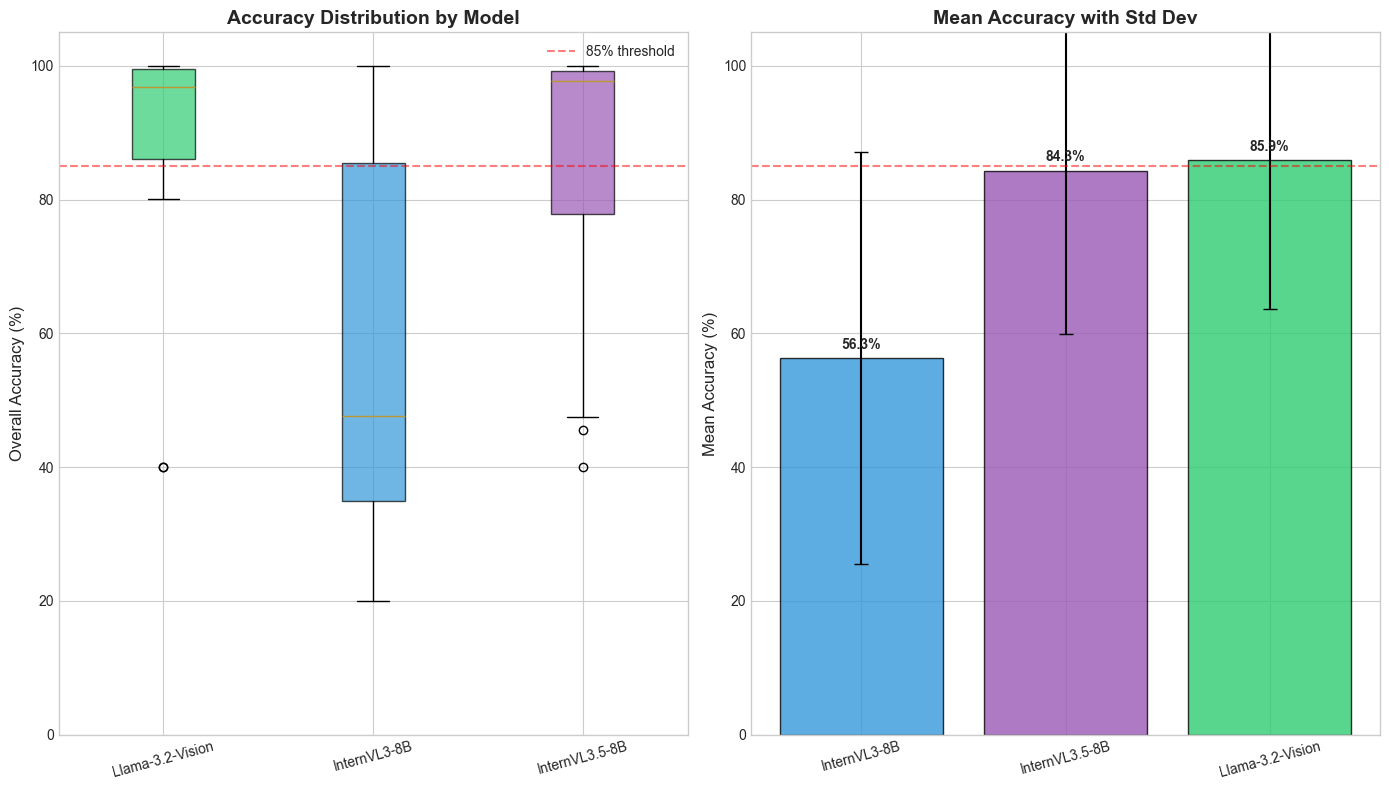


📊 Saved: bank_accuracy_comparison.png


In [4]:
if not combined_df.empty:
    fig, axes = plt.subplots(1, 2, figsize=CONFIG['figure_size'])
    
    # Box plot of accuracy distribution
    ax1 = axes[0]
    models = combined_df['model'].unique()
    colors = [MODEL_COLORS.get(m, '#95a5a6') for m in models]
    
    box_data = [combined_df[combined_df['model'] == m]['overall_accuracy'] * 100 for m in models]
    bp = ax1.boxplot(box_data, labels=models, patch_artist=True)
    
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax1.set_ylabel('Overall Accuracy (%)', fontsize=12)
    ax1.set_title('Accuracy Distribution by Model', fontsize=14, fontweight='bold')
    ax1.tick_params(axis='x', rotation=15)
    ax1.set_ylim([0, 105])
    ax1.axhline(y=85, color='red', linestyle='--', alpha=0.5, label='85% threshold')
    ax1.legend()
    
    # Bar chart of mean accuracy
    ax2 = axes[1]
    means = combined_df.groupby('model')['overall_accuracy'].mean() * 100
    stds = combined_df.groupby('model')['overall_accuracy'].std() * 100
    
    bars = ax2.bar(means.index, means.values, 
                   color=[MODEL_COLORS.get(m, '#95a5a6') for m in means.index],
                   alpha=0.8, edgecolor='black')
    ax2.errorbar(means.index, means.values, yerr=stds.values, 
                 fmt='none', color='black', capsize=5)
    
    # Add value labels
    for bar, val in zip(bars, means.values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    ax2.set_ylabel('Mean Accuracy (%)', fontsize=12)
    ax2.set_title('Mean Accuracy with Std Dev', fontsize=14, fontweight='bold')
    ax2.tick_params(axis='x', rotation=15)
    ax2.set_ylim([0, 105])
    ax2.axhline(y=85, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(f"{CONFIG['output_dir']}/bank_accuracy_comparison.png", dpi=CONFIG['dpi'], bbox_inches='tight')
    plt.show()
    print(f"\n📊 Saved: bank_accuracy_comparison.png")

## 5. Processing Time Comparison

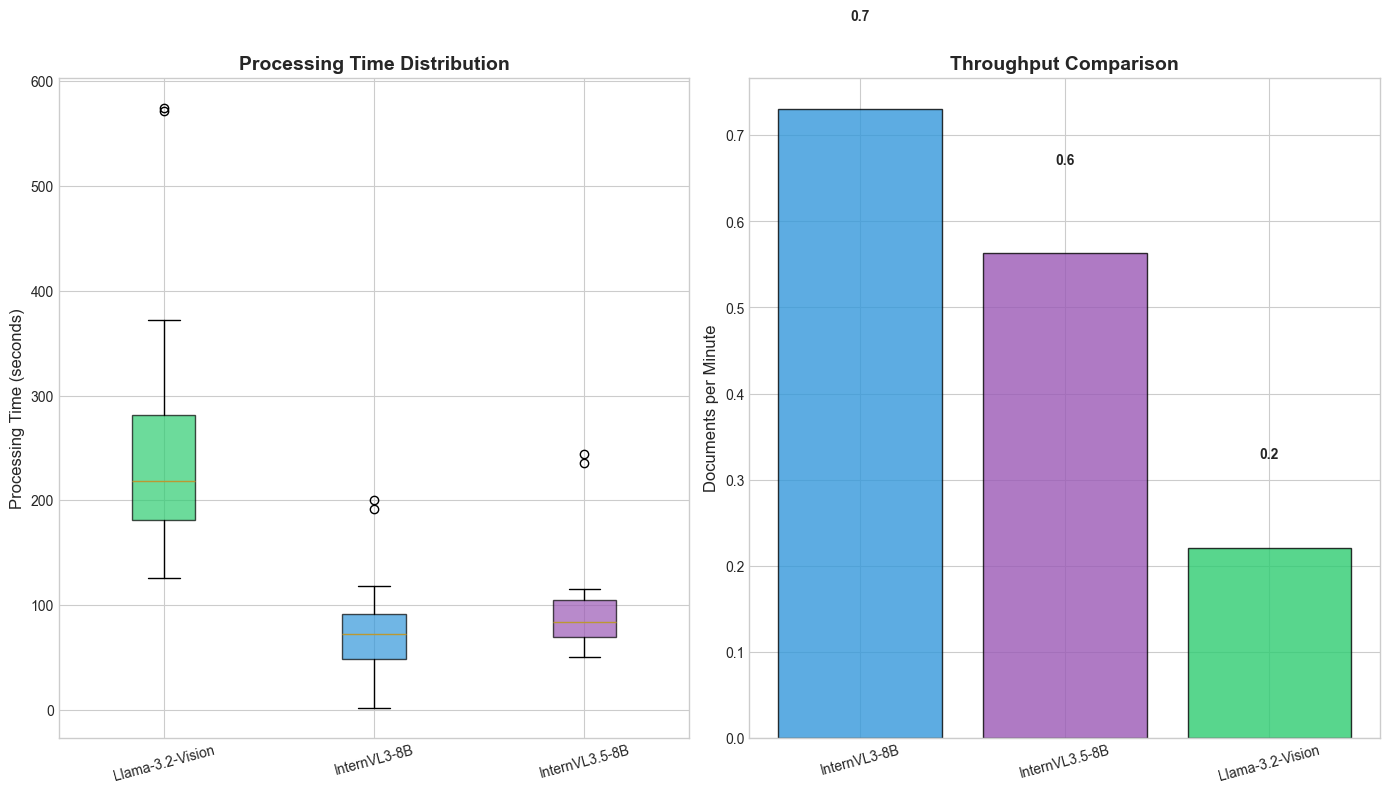


📊 Saved: bank_processing_time.png


In [5]:
if not combined_df.empty:
    fig, axes = plt.subplots(1, 2, figsize=CONFIG['figure_size'])
    
    # Box plot of processing times
    ax1 = axes[0]
    models = combined_df['model'].unique()
    colors = [MODEL_COLORS.get(m, '#95a5a6') for m in models]
    
    box_data = [combined_df[combined_df['model'] == m]['processing_time'] for m in models]
    bp = ax1.boxplot(box_data, labels=models, patch_artist=True)
    
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax1.set_ylabel('Processing Time (seconds)', fontsize=12)
    ax1.set_title('Processing Time Distribution', fontsize=14, fontweight='bold')
    ax1.tick_params(axis='x', rotation=15)
    
    # Throughput comparison (docs per minute)
    ax2 = axes[1]
    avg_times = combined_df.groupby('model')['processing_time'].mean()
    throughput = 60 / avg_times  # documents per minute
    
    bars = ax2.bar(throughput.index, throughput.values,
                   color=[MODEL_COLORS.get(m, '#95a5a6') for m in throughput.index],
                   alpha=0.8, edgecolor='black')
    
    for bar, val in zip(bars, throughput.values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{val:.1f}', ha='center', va='bottom', fontweight='bold')
    
    ax2.set_ylabel('Documents per Minute', fontsize=12)
    ax2.set_title('Throughput Comparison', fontsize=14, fontweight='bold')
    ax2.tick_params(axis='x', rotation=15)
    
    plt.tight_layout()
    plt.savefig(f"{CONFIG['output_dir']}/bank_processing_time.png", dpi=CONFIG['dpi'], bbox_inches='tight')
    plt.show()
    print(f"\n📊 Saved: bank_processing_time.png")

## 6. Field-Level Performance (F1 Scores)

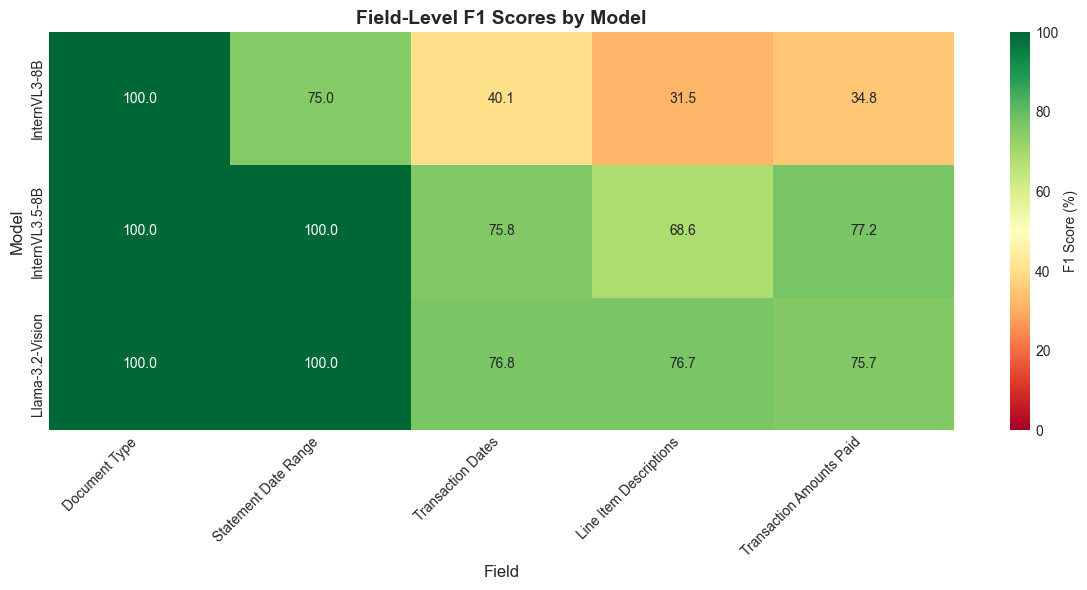


📊 Saved: bank_field_f1_heatmap.png

📋 Field F1 Scores (%):



,Document Type,Statement Date Range,Transaction Dates,Line Item Descriptions,Transaction Amounts Paid
model,,,,,
InternVL3-8B,100.0,75.0,40.1,31.5,34.8
InternVL3.5-8B,100.0,100.0,75.8,68.6,77.2
Llama-3.2-Vision,100.0,100.0,76.8,76.7,75.7


In [6]:
if not combined_df.empty:
    # Find F1 score columns
    f1_cols = [col for col in combined_df.columns if col.endswith('_f1')]
    
    if f1_cols:
        # Calculate mean F1 per field per model
        field_performance = combined_df.groupby('model')[f1_cols].mean() * 100
        
        # Rename columns for display
        field_performance.columns = [col.replace('_f1', '').replace('_', ' ').title() 
                                      for col in field_performance.columns]
        
        # Create heatmap
        fig, ax = plt.subplots(figsize=(12, 6))
        
        sns.heatmap(field_performance, annot=True, fmt='.1f', cmap='RdYlGn',
                    vmin=0, vmax=100, ax=ax, cbar_kws={'label': 'F1 Score (%)'})
        
        ax.set_title('Field-Level F1 Scores by Model', fontsize=14, fontweight='bold')
        ax.set_xlabel('Field', fontsize=12)
        ax.set_ylabel('Model', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        plt.savefig(f"{CONFIG['output_dir']}/bank_field_f1_heatmap.png", dpi=CONFIG['dpi'], bbox_inches='tight')
        plt.show()
        print(f"\n📊 Saved: bank_field_f1_heatmap.png")
        
        # Display as table
        print("\n📋 Field F1 Scores (%):\n")
        display(field_performance.round(1))
    else:
        print("⚠️ No F1 score columns found in data")

## 7. Per-Document Performance

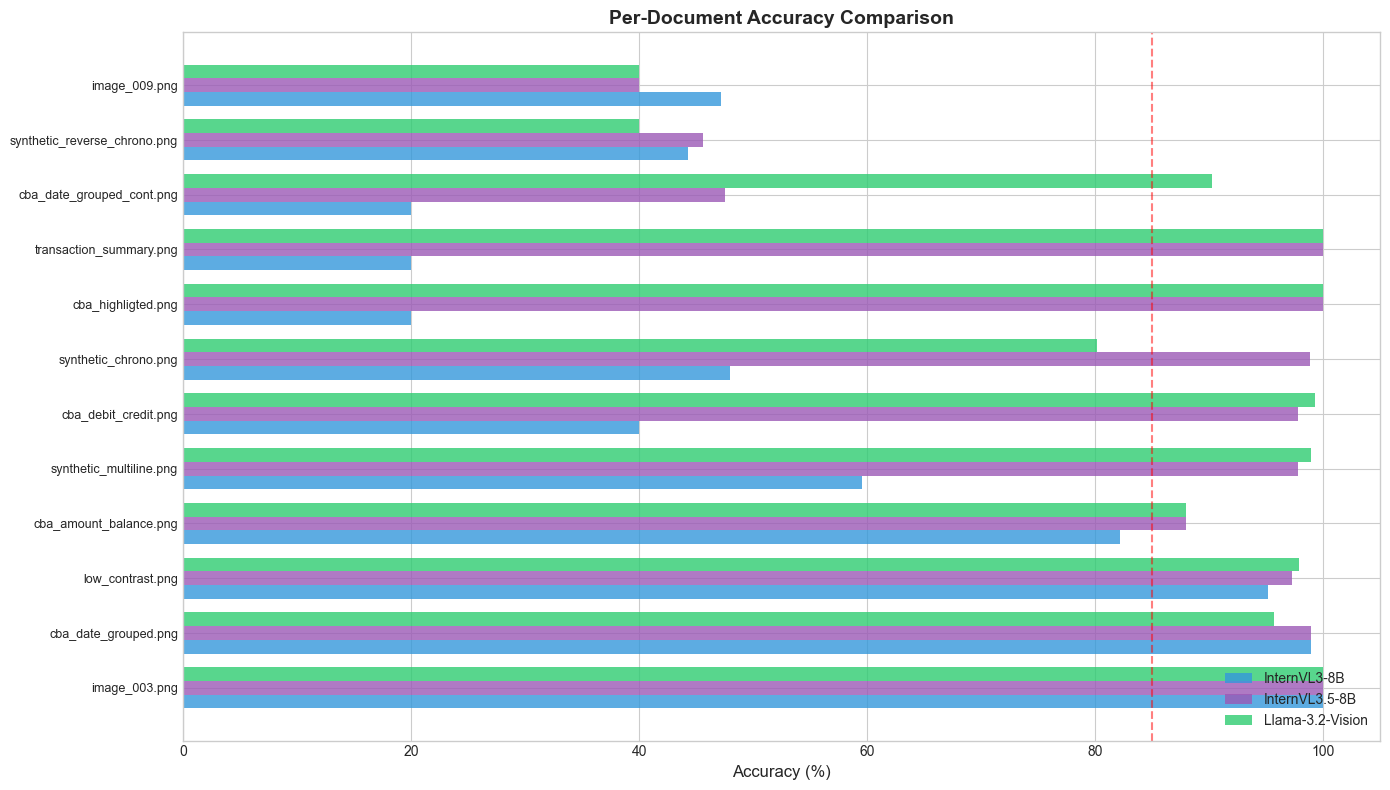


📊 Saved: bank_per_document.png

📋 Per-Document Accuracy (%):



model,InternVL3-8B,InternVL3.5-8B,Llama-3.2-Vision
image_file,,,
image_003.png,100.0,100.0,100.0
cba_date_grouped.png,98.9,98.9,95.7
low_contrast.png,95.2,97.3,97.9
cba_amount_balance.png,82.2,88.0,88.0
synthetic_multiline.png,59.5,97.8,98.9
cba_debit_credit.png,40.0,97.8,99.3
synthetic_chrono.png,48.0,98.8,80.1
cba_highligted.png,20.0,100.0,100.0
transaction_summary.png,20.0,100.0,100.0


In [7]:
if not combined_df.empty:
    # Pivot to compare models side by side
    pivot_df = combined_df.pivot_table(
        index='image_file',
        columns='model',
        values='overall_accuracy',
        aggfunc='first'
    ) * 100
    
    # Sort by average accuracy
    pivot_df['avg'] = pivot_df.mean(axis=1)
    pivot_df = pivot_df.sort_values('avg', ascending=False)
    pivot_df = pivot_df.drop('avg', axis=1)
    
    # Create comparison chart
    fig, ax = plt.subplots(figsize=(14, max(8, len(pivot_df) * 0.4)))
    
    x = np.arange(len(pivot_df))
    width = 0.25
    
    models = [col for col in pivot_df.columns if col in MODEL_COLORS]
    
    for i, model in enumerate(models):
        if model in pivot_df.columns:
            offset = (i - len(models)/2 + 0.5) * width
            ax.barh(x + offset, pivot_df[model], width,
                   label=model, color=MODEL_COLORS.get(model, '#95a5a6'), alpha=0.8)
    
    ax.set_yticks(x)
    ax.set_yticklabels(pivot_df.index, fontsize=9)
    ax.set_xlabel('Accuracy (%)', fontsize=12)
    ax.set_title('Per-Document Accuracy Comparison', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.axvline(x=85, color='red', linestyle='--', alpha=0.5, label='85% threshold')
    ax.set_xlim([0, 105])
    
    plt.tight_layout()
    plt.savefig(f"{CONFIG['output_dir']}/bank_per_document.png", dpi=CONFIG['dpi'], bbox_inches='tight')
    plt.show()
    print(f"\n📊 Saved: bank_per_document.png")
    
    # Display table
    print("\n📋 Per-Document Accuracy (%):\n")
    display(pivot_df.round(1))

## 8. Accuracy vs Speed Trade-off

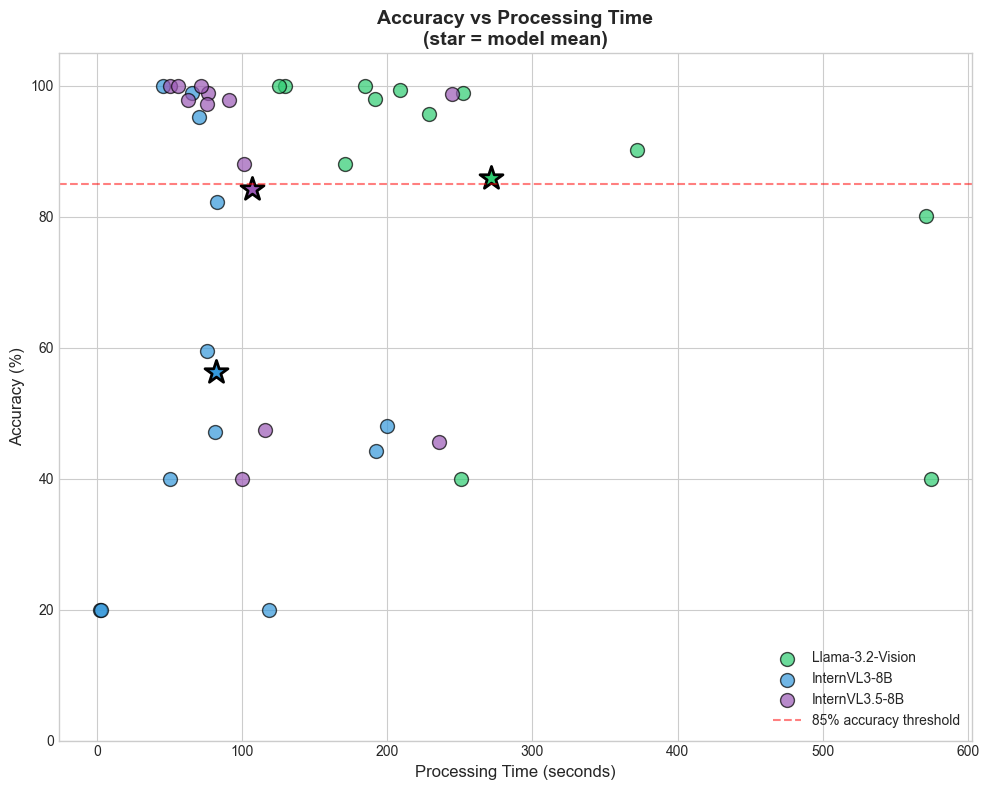


📊 Saved: bank_accuracy_vs_time.png


In [8]:
if not combined_df.empty:
    fig, ax = plt.subplots(figsize=(10, 8))
    
    for model in combined_df['model'].unique():
        model_data = combined_df[combined_df['model'] == model]
        ax.scatter(model_data['processing_time'], 
                  model_data['overall_accuracy'] * 100,
                  c=MODEL_COLORS.get(model, '#95a5a6'),
                  label=model, alpha=0.7, s=100, edgecolors='black')
    
    # Add means as larger markers
    for model in combined_df['model'].unique():
        model_data = combined_df[combined_df['model'] == model]
        mean_time = model_data['processing_time'].mean()
        mean_acc = model_data['overall_accuracy'].mean() * 100
        ax.scatter(mean_time, mean_acc, c=MODEL_COLORS.get(model, '#95a5a6'),
                  s=300, marker='*', edgecolors='black', linewidths=2)
    
    ax.axhline(y=85, color='red', linestyle='--', alpha=0.5, label='85% accuracy threshold')
    ax.set_xlabel('Processing Time (seconds)', fontsize=12)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title('Accuracy vs Processing Time\n(star = model mean)', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.set_ylim([0, 105])
    
    plt.tight_layout()
    plt.savefig(f"{CONFIG['output_dir']}/bank_accuracy_vs_time.png", dpi=CONFIG['dpi'], bbox_inches='tight')
    plt.show()
    print(f"\n📊 Saved: bank_accuracy_vs_time.png")

## 9. Problem Documents Analysis

In [9]:
if not combined_df.empty:
    # Find documents where accuracy < 85%
    threshold = 0.85
    
    problem_docs = combined_df[combined_df['overall_accuracy'] < threshold].copy()
    
    if len(problem_docs) > 0:
        print(f"⚠️ Documents below {threshold*100:.0f}% accuracy:\n")
        
        problem_summary = problem_docs.groupby('image_file').agg({
            'model': lambda x: ', '.join(x),
            'overall_accuracy': 'mean'
        }).sort_values('overall_accuracy')
        
        problem_summary['overall_accuracy'] = (problem_summary['overall_accuracy'] * 100).round(1)
        problem_summary.columns = ['Models Below Threshold', 'Avg Accuracy (%)']
        
        display(problem_summary)
        
        print(f"\n📊 {len(problem_summary)} documents have at least one model below {threshold*100:.0f}%")
    else:
        rprint(f"[green]✅ All documents above {threshold*100:.0f}% accuracy for all models![/green]")

⚠️ Documents below 85% accuracy:



,Models Below Threshold,Avg Accuracy (%)
image_file,,
cba_highligted.png,InternVL3-8B,20.0
transaction_summary.png,InternVL3-8B,20.0
cba_date_grouped_cont.png,"InternVL3-8B, InternVL3.5-8B",33.8
cba_debit_credit.png,InternVL3-8B,40.0
image_009.png,"Llama-3.2-Vision, InternVL3-8B, InternVL3.5-8B",42.4
synthetic_reverse_chrono.png,"Llama-3.2-Vision, InternVL3-8B, InternVL3.5-8B",43.3
synthetic_multiline.png,InternVL3-8B,59.5
synthetic_chrono.png,"Llama-3.2-Vision, InternVL3-8B",64.1
cba_amount_balance.png,InternVL3-8B,82.2



📊 9 documents have at least one model below 85%


## 10. Recommendation Summary

In [10]:
if not combined_df.empty:
    print("="*60)
    print("BANK STATEMENT EXTRACTION: MODEL RECOMMENDATION")
    print("="*60)
    
    # Summary stats
    stats = combined_df.groupby('model').agg({
        'overall_accuracy': 'mean',
        'processing_time': 'mean'
    })
    
    best_accuracy = stats['overall_accuracy'].idxmax()
    fastest = stats['processing_time'].idxmin()
    
    print(f"\n📊 Results Summary:")
    print(f"   • Documents tested: {combined_df['image_file'].nunique()}")
    print(f"   • Models compared: {combined_df['model'].nunique()}")
    
    print(f"\n🏆 Best Accuracy: {best_accuracy}")
    print(f"   • {stats.loc[best_accuracy, 'overall_accuracy']*100:.1f}% average accuracy")
    
    print(f"\n⚡ Fastest Processing: {fastest}")
    print(f"   • {stats.loc[fastest, 'processing_time']:.1f}s average per document")
    
    # Calculate efficiency score (accuracy per second)
    stats['efficiency'] = stats['overall_accuracy'] / stats['processing_time']
    best_efficiency = stats['efficiency'].idxmax()
    
    print(f"\n📈 Best Efficiency (accuracy/time): {best_efficiency}")
    
    print(f"\n" + "="*60)
    print("RECOMMENDATION:")
    print("="*60)
    
    if best_accuracy == fastest:
        print(f"\n✅ {best_accuracy} is recommended")
        print("   (Best in both accuracy AND speed)")
    else:
        acc_diff = (stats.loc[best_accuracy, 'overall_accuracy'] - stats.loc[fastest, 'overall_accuracy']) * 100
        time_ratio = stats.loc[best_accuracy, 'processing_time'] / stats.loc[fastest, 'processing_time']
        
        print(f"\n• For maximum accuracy: {best_accuracy}")
        print(f"  ({acc_diff:.1f}% more accurate, {time_ratio:.1f}x slower)")
        print(f"\n• For speed priority: {fastest}")
        print(f"  (Faster but slightly lower accuracy)")
        print(f"\n• Best overall value: {best_efficiency}")

BANK STATEMENT EXTRACTION: MODEL RECOMMENDATION

📊 Results Summary:
   • Documents tested: 12
   • Models compared: 3

🏆 Best Accuracy: Llama-3.2-Vision
   • 85.9% average accuracy

⚡ Fastest Processing: InternVL3-8B
   • 82.2s average per document

📈 Best Efficiency (accuracy/time): InternVL3.5-8B

RECOMMENDATION:

• For maximum accuracy: Llama-3.2-Vision
  (29.6% more accurate, 3.3x slower)

• For speed priority: InternVL3-8B
  (Faster but slightly lower accuracy)

• Best overall value: InternVL3.5-8B


## 11. Executive Dashboard

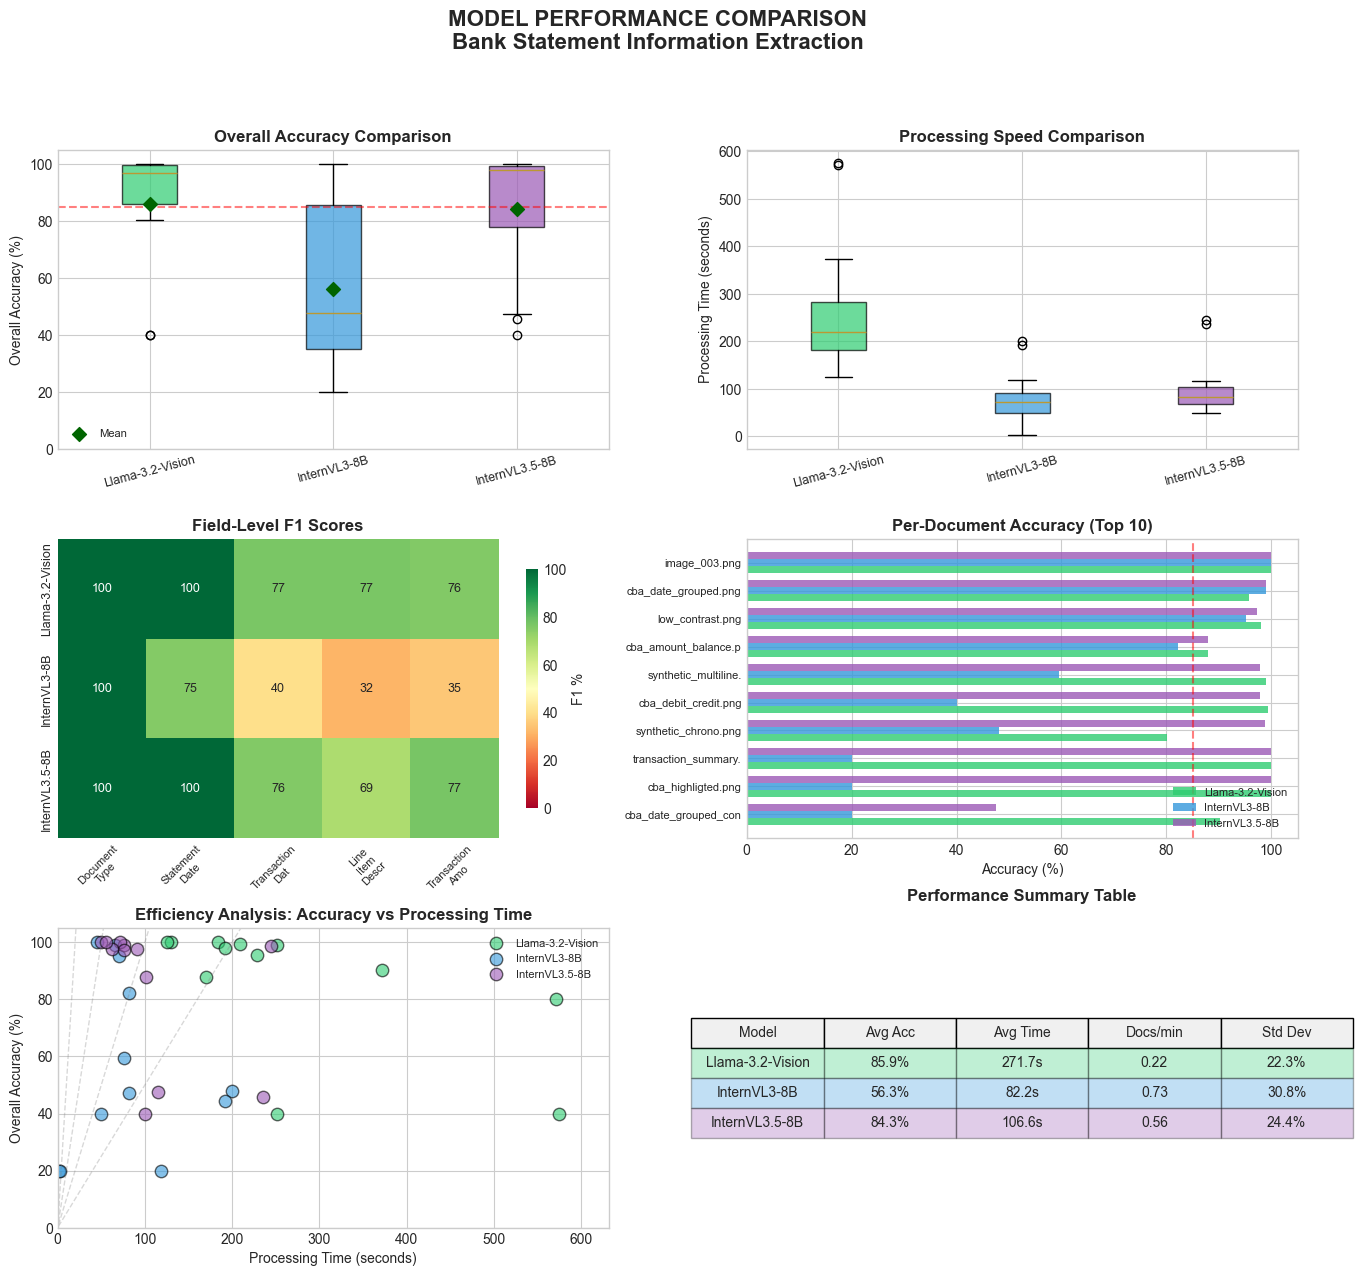


📊 Saved: bank_model_dashboard.png


In [11]:
if not combined_df.empty:
    # Create executive dashboard - 3x2 grid with summary table
    fig = plt.figure(figsize=(16, 14))
    
    # Main title
    fig.suptitle('MODEL PERFORMANCE COMPARISON\nBank Statement Information Extraction', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Define grid: 3 rows x 2 columns
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1], hspace=0.3, wspace=0.25)
    
    models = list(MODEL_COLORS.keys())
    colors = [MODEL_COLORS[m] for m in models if m in combined_df['model'].unique()]
    models_present = [m for m in models if m in combined_df['model'].unique()]
    
    # ============ Row 1: Accuracy Box Plot & Processing Time Box Plot ============
    
    # 1. Overall Accuracy Comparison (box plot)
    ax1 = fig.add_subplot(gs[0, 0])
    box_data = [combined_df[combined_df['model'] == m]['overall_accuracy'] * 100 
                for m in models_present]
    bp1 = ax1.boxplot(box_data, labels=models_present, patch_artist=True)
    for patch, color in zip(bp1['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    # Add mean markers
    means = [combined_df[combined_df['model'] == m]['overall_accuracy'].mean() * 100 
             for m in models_present]
    ax1.scatter(range(1, len(models_present)+1), means, color='darkgreen', 
                marker='D', s=50, zorder=5, label='Mean')
    ax1.set_ylabel('Overall Accuracy (%)', fontsize=10)
    ax1.set_title('Overall Accuracy Comparison', fontsize=12, fontweight='bold')
    ax1.tick_params(axis='x', rotation=15, labelsize=9)
    ax1.set_ylim([0, 105])
    ax1.axhline(y=85, color='red', linestyle='--', alpha=0.5)
    ax1.legend(loc='lower left', fontsize=8)
    
    # 2. Processing Speed Comparison (box plot)
    ax2 = fig.add_subplot(gs[0, 1])
    box_data_time = [combined_df[combined_df['model'] == m]['processing_time'] 
                     for m in models_present]
    bp2 = ax2.boxplot(box_data_time, labels=models_present, patch_artist=True)
    for patch, color in zip(bp2['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax2.set_ylabel('Processing Time (seconds)', fontsize=10)
    ax2.set_title('Processing Speed Comparison', fontsize=12, fontweight='bold')
    ax2.tick_params(axis='x', rotation=15, labelsize=9)
    
    # ============ Row 2: Field F1 Heatmap & Per-Image Bar Chart ============
    
    # 3. Field-Level F1 Scores (heatmap)
    ax3 = fig.add_subplot(gs[1, 0])
    f1_cols = [col for col in combined_df.columns if col.endswith('_f1')]
    if f1_cols:
        field_perf = combined_df.groupby('model')[f1_cols].mean() * 100
        # Reorder rows to match MODEL_COLORS order
        field_perf = field_perf.reindex([m for m in models_present if m in field_perf.index])
        field_perf.columns = [col.replace('_f1', '').replace('_', '\n').title()[:15] 
                              for col in field_perf.columns]
        sns.heatmap(field_perf, annot=True, fmt='.0f', cmap='RdYlGn',
                    vmin=0, vmax=100, ax=ax3, cbar_kws={'label': 'F1 %', 'shrink': 0.8},
                    annot_kws={'size': 9})
        ax3.set_title('Field-Level F1 Scores', fontsize=12, fontweight='bold')
        ax3.set_xlabel('')
        ax3.set_ylabel('')
        ax3.tick_params(axis='x', rotation=45, labelsize=8)
        ax3.tick_params(axis='y', labelsize=9)
    
    # 4. Per-Image Accuracy (grouped bar)
    ax4 = fig.add_subplot(gs[1, 1])
    pivot_df = combined_df.pivot_table(
        index='image_file', columns='model', values='overall_accuracy', aggfunc='first'
    ) * 100
    # Sort by mean and take top 8 for readability
    pivot_df['avg'] = pivot_df.mean(axis=1)
    pivot_df = pivot_df.sort_values('avg', ascending=True).tail(10).drop('avg', axis=1)
    
    x = np.arange(len(pivot_df))
    width = 0.25
    for i, model in enumerate(models_present):
        if model in pivot_df.columns:
            offset = (i - len(models_present)/2 + 0.5) * width
            ax4.barh(x + offset, pivot_df[model], width, label=model, 
                    color=MODEL_COLORS[model], alpha=0.8)
    ax4.set_yticks(x)
    ax4.set_yticklabels([f[:20] for f in pivot_df.index], fontsize=8)
    ax4.set_xlabel('Accuracy (%)', fontsize=10)
    ax4.set_title('Per-Document Accuracy (Top 10)', fontsize=12, fontweight='bold')
    ax4.axvline(x=85, color='red', linestyle='--', alpha=0.5)
    ax4.set_xlim([0, 105])
    ax4.legend(loc='lower right', fontsize=8)
    
    # ============ Row 3: Efficiency Scatter & Summary Table ============
    
    # 5. Efficiency Analysis (scatter plot)
    ax5 = fig.add_subplot(gs[2, 0])
    for model in models_present:
        model_data = combined_df[combined_df['model'] == model]
        ax5.scatter(model_data['processing_time'], 
                   model_data['overall_accuracy'] * 100,
                   c=MODEL_COLORS[model], label=model, alpha=0.6, s=80, edgecolors='black')
    # Add iso-efficiency lines
    for eff in [0.5, 1.0, 2.0, 5.0]:
        x_line = np.linspace(1, combined_df['processing_time'].max() * 1.1, 100)
        y_line = eff * x_line
        ax5.plot(x_line, y_line, '--', color='gray', alpha=0.3, linewidth=1)
    ax5.set_xlabel('Processing Time (seconds)', fontsize=10)
    ax5.set_ylabel('Overall Accuracy (%)', fontsize=10)
    ax5.set_title('Efficiency Analysis: Accuracy vs Processing Time', fontsize=12, fontweight='bold')
    ax5.legend(loc='upper right', fontsize=8)
    ax5.set_ylim([0, 105])
    ax5.set_xlim([0, combined_df['processing_time'].max() * 1.1])
    
    # 6. Performance Summary Table
    ax6 = fig.add_subplot(gs[2, 1])
    ax6.axis('off')
    
    # Calculate summary stats
    summary_data = []
    for model in models_present:
        model_data = combined_df[combined_df['model'] == model]
        avg_acc = model_data['overall_accuracy'].mean() * 100
        avg_time = model_data['processing_time'].mean()
        docs_min = 60 / avg_time
        std_dev = model_data['overall_accuracy'].std() * 100
        summary_data.append([model, f'{avg_acc:.1f}%', f'{avg_time:.1f}s', 
                            f'{docs_min:.2f}', f'{std_dev:.1f}%'])
    
    # Create table
    table = ax6.table(
        cellText=summary_data,
        colLabels=['Model', 'Avg Acc', 'Avg Time', 'Docs/min', 'Std Dev'],
        loc='center',
        cellLoc='center',
        colColours=['#f0f0f0'] * 5
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.8)
    
    # Color code rows by model
    for i, model in enumerate(models_present):
        for j in range(5):
            table[(i+1, j)].set_facecolor(MODEL_COLORS[model])
            table[(i+1, j)].set_alpha(0.3)
    
    ax6.set_title('Performance Summary Table', fontsize=12, fontweight='bold', pad=20)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f"{CONFIG['output_dir']}/bank_model_dashboard.png", dpi=200, 
                bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"\n📊 Saved: bank_model_dashboard.png")

---

## Export Summary

In [12]:
if not combined_df.empty:
    # Export combined results
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    export_path = f"{CONFIG['output_dir']}/bank_model_comparison_{timestamp}.csv"
    combined_df.to_csv(export_path, index=False)
    
    print(f"📁 Exported combined results to: {export_path}")
    print(f"\n📊 Charts saved to: {CONFIG['output_dir']}/")
    print("   • bank_accuracy_comparison.png")
    print("   • bank_processing_time.png")
    print("   • bank_field_f1_heatmap.png")
    print("   • bank_per_document.png")
    print("   • bank_accuracy_vs_time.png")

📁 Exported combined results to: /Users/tod/Desktop/LMM_POC/output/bank_model_comparison_20251206_093002.csv

📊 Charts saved to: /Users/tod/Desktop/LMM_POC/output/
   • bank_accuracy_comparison.png
   • bank_processing_time.png
   • bank_field_f1_heatmap.png
   • bank_per_document.png
   • bank_accuracy_vs_time.png
